In [2]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from moonpies import moonpies as mp
from moonpies import default_config

data_dirs = {
    ' Ballistic Sedimentation':'/home/cjtu/projects/moonpies/data/out/220224_mpies/',
    ' No Ballistic Sedimentation':'/home/cjtu/projects/moonpies/data/out/220221_nobsed/' 
}
figdir = '/home/cjtu/projects/moonpies/figures/'
tmpdir = '/home/cjtu/projects/moonpies/data/tmp/'
datatmp = Path(tmpdir).joinpath('220224_ice_depth_data.pkl')

# Set ice column
coldtraps = ['Haworth', 'Shoemaker', 'Faustini', 'Cabeus']
crater_list = mp.read_crater_list()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
if datatmp.exists():
    with open(datatmp, 'rb') as f:
        data = pickle.load(f)
else:
    data = {}
    for coldtrap in coldtraps:
        print('\n', coldtrap, end='')
        for isbsed, data_dir in data_dirs.items():
            csvs = Path(data_dir).rglob(f'strat_{coldtrap}.csv')
            ices, depths, ice_tot = [], [], []
            for i, csv in enumerate(csvs):
                mp.clear_cache()
                fcfg = csv.parent.joinpath('run_config_mpies.py')
                cfg = default_config.Cfg(**default_config.read_custom_cfg(fcfg))
                craters = mp.get_crater_list(cfg=cfg, rng=mp.get_rng(cfg))
                age = craters[craters.cname==coldtrap].age.values[0]
                ice, time, depth = pd.read_csv(csv, usecols=[0, 3, 4]).values.T
                # Pull ices and depths after coldtrap formed
                ices.extend(ice[time<=age])
                depths.extend(depth[time<=age])
                ice_tot.append(ice[time<=age].sum())
                if i%10==0:
                    print('.', end='', flush=True)
            data[coldtrap+isbsed] = (np.array(ices), np.array(depths), np.array(ice_tot))
    with open(datatmp, 'wb') as f:
        pickle.dump(data, f)

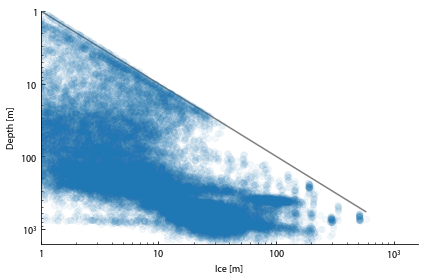

In [3]:
# Haworth no bsed
haworth_nobsed = data['Haworth No Ballistic Sedimentation']
ices, depths, ice_tot = haworth_nobsed
x = np.geomspace(0.1, max(ices))
plt.plot(x, x, 'gray')
plt.loglog(ices, depths, 'o', alpha=0.05)
plt.xlabel('Ice [m]')
plt.ylabel('Depth [m]')
plt.xlim(1, max(depths))
plt.ylim(1, max(depths))
plt.grid(b=None)
ax = plt.gca()
ax.invert_yaxis()

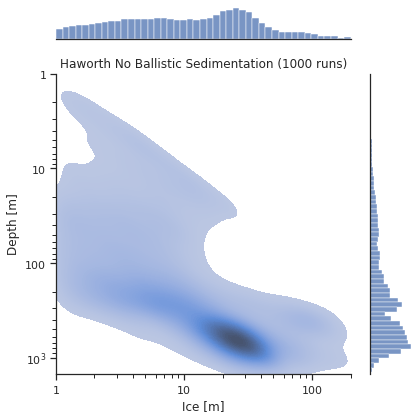

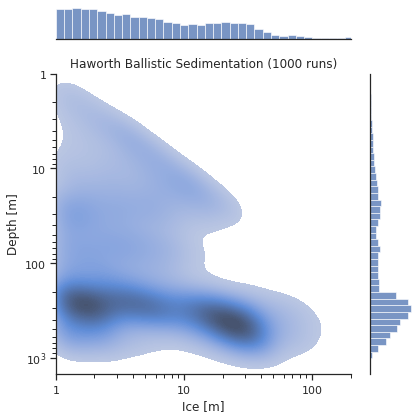

In [5]:
def plot_ice_depth_kde(ices, depths, title='', min_ice=1, min_depth=1, max_ice=None, max_depth=None, savefig=False):
    subset = (ices > min_ice) & (depths > min_depth)
    X = ices[subset] 
    Y = depths[subset]

    jg = sns.JointGrid()
    sns.kdeplot(x=X, y=Y, thresh=0.05, levels=100, common_norm=True, 
                log_scale=True, fill=True, ax=jg.ax_joint)
    sns.histplot(x=X, ax=jg.ax_marg_x)
    sns.histplot(y=Y, ax=jg.ax_marg_y)

    jg.ax_joint.set_title(title)
    jg.ax_joint.set_xlim(1, max_ice)
    jg.ax_joint.set_ylim(1, max_depth)
    jg.ax_joint.set_xscale('log')
    jg.ax_joint.set_yscale('log')
    jg.ax_joint.invert_yaxis()
    jg.ax_joint.set_xlabel('Ice [m]')
    jg.ax_joint.set_ylabel('Depth [m]')

    jg.ax_marg_x.yaxis.get_major_formatter().set_scientific(False)
    jg.ax_marg_y.xaxis.get_major_formatter().set_scientific(False)
    jg.ax_marg_x.xaxis.set_visible(False)
    jg.ax_marg_y.yaxis.set_visible(False)

    # cbar = jg.fig.axes[-1]
    # cmin, cmax = jg.fig.axes[-1].get_ylim()
    # cbar.colorbar.set_clim(cmin, cmax*10)
    # cbar.set_yticklabels([f'{t / cmax * 100:.1f} %' for t in cbar.get_yticks()])
    if savefig:
        jg.fig.savefig(f'{title}.png', dpi=300)
    else:
        plt.show()

ices, depths, ice_tot = data['Haworth No Ballistic Sedimentation']
plot_ice_depth_kde(ices, depths, max_ice=200, max_depth=1.5e3, title='Haworth No Ballistic Sedimentation (1000 runs)', savefig=True)
ices, depths, ice_tot = data['Haworth Ballistic Sedimentation']
plot_ice_depth_kde(ices, depths, max_ice=200, max_depth=1.5e3, title='Haworth Ballistic Sedimentation (1000 runs)', savefig=True)

KeyboardInterrupt: 

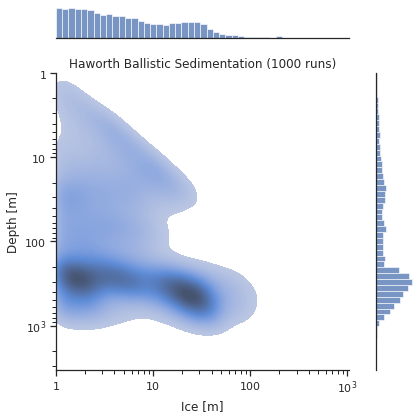

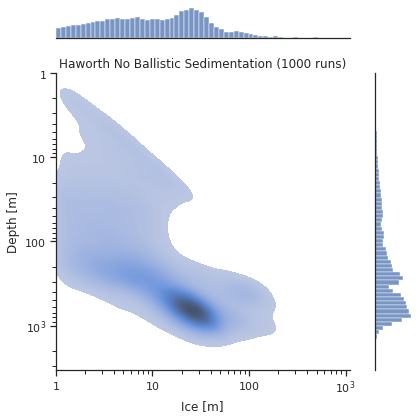

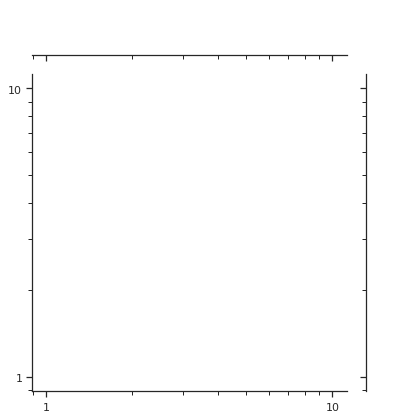

In [5]:
a = []
for key in data:
    ices = data[key][0]
    depths = data[key][1]
    ice_tot = data[key][2]
    plot_ice_depth_kde(ices, depths, title=key+' (1000 runs)', savefig=True)

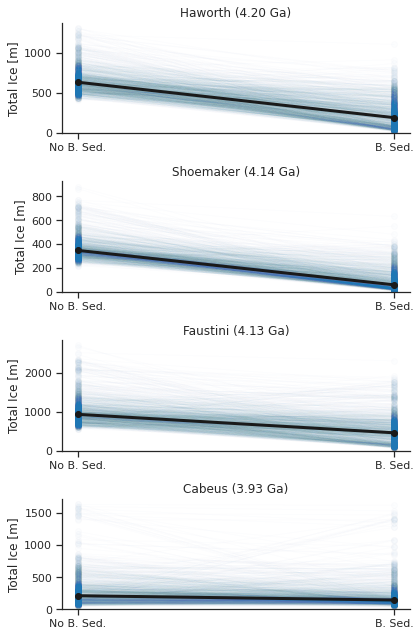

In [ ]:
f, axs = plt.subplots(len(coldtraps), 1, figsize=(6, 9))
for coldtrap, ax in zip(coldtraps, axs):
    ice_tot_nbsed = data[coldtrap+' No Ballistic Sedimentation'][2]
    ice_tot_bsed = data[coldtrap+' Ballistic Sedimentation'][2]
    for ynbsed, ybsed in zip(ice_tot_nbsed, ice_tot_bsed):
        ax.plot([0, 1], [ynbsed, ybsed], '-o', alpha=0.01, lw=1, c='tab:blue')
    ax.plot([0, 1], [np.median(ice_tot_nbsed), np.median(ice_tot_bsed)], '-o', lw=3, c='k')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No B. Sed.', 'B. Sed.'])
    age = float(crater_list[crater_list.cname == coldtrap].age.values)/1e9
    ax.set_title(coldtrap + f' ({age:.2f} Ga)')
    ax.set_ylabel('Total Ice [m]')
    ax.set_ylim(0, None)
    ax.grid(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
f.savefig(figdir + 'bsed_nobsed_compare.png', dpi=300)

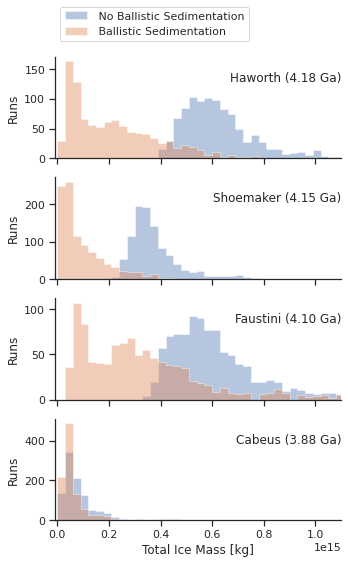

In [6]:
def get_ice_mass(ice_thickness, area, density):
    return ice_thickness * area * density
f, axs = plt.subplots(len(coldtraps), 1, sharex=True, figsize=(5, 8))
f.subplots_adjust(hspace=0)
xmax = 1.5e15
for coldtrap, ax in zip(coldtraps, axs):
    for isbsed in [' No Ballistic Sedimentation', ' Ballistic Sedimentation']:
        ice_tot = data[coldtrap+isbsed][2]
        area = crater_list[crater_list.cname == coldtrap].psr_area.values
        ice_mass = get_ice_mass(ice_tot, area, default_config.Cfg().ice_density)
        ax.hist(ice_mass, bins=50, alpha=0.4, histtype='stepfilled', range=(0, xmax), label=isbsed)
        age = float(crater_list[crater_list.cname == coldtrap].age.values)/1e9
        ax.set_title(coldtrap + f' ({age:.2f} Ga)',loc='right', y=0.7)
        ax.set_ylabel('Runs')
        ax.set_xlim(-1e13, 1.1e15)
axs[0].legend(bbox_to_anchor=(0, 1.1), loc='lower left')
axs[-1].set_xlabel('Total Ice Mass [kg]')
f.savefig(figdir + 'bsed_compare_mass_hist.png', dpi=300)

Text(0.5, 0, 'Ice Mass [kg]')

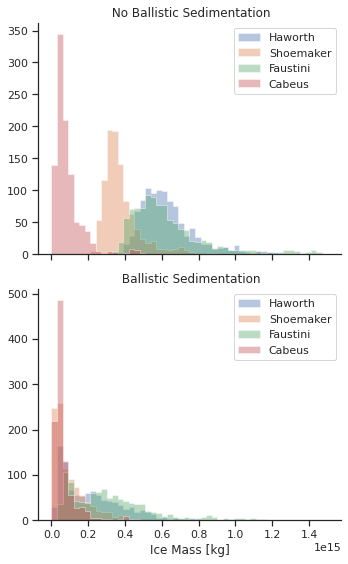

In [15]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
for isbsed, ax in zip([' No Ballistic Sedimentation', ' Ballistic Sedimentation'], axs):
    for coldtrap in coldtraps:
        ice_tot = data[coldtrap+isbsed][2]
        area = crater_list[crater_list.cname == coldtrap].psr_area.values
        ice_mass = get_ice_mass(ice_tot, area, default_config.Cfg().ice_density)
        ax.hist(ice_mass, bins=50, alpha=0.4, histtype='stepfilled', range=(0, 1.5e15), density=False, label=coldtrap)
        ax.legend()
    ax.set_title(isbsed)
axs[1].set_xlabel('Ice Mass [kg]')


In [ ]:
# csvs = Path(data_dir).rglob(f'ice_columns_*.csv')
csvs = Path(data_dir).rglob(f'strat_{coldtrap}.csv')

for i, csv in enumerate(csvs):
        time, ice_col = pd.read_csv(csv, usecols=[0, col]).values.T
        ax.plot(time/1e9, ice_col)
        if i % 100 == 0:
            print(f'Starting csv {i}: {csv}', flush=True)
if 'i' not in locals():
    print(f'No ice_columns csvs found, check DATA_DIR: {data_dir}')
    quit()
else:
    print(f'Finished csv {i}: {csv}', flush=True)

# Configure and save figure
f, ax = plt.subplots()
ax.set_xlabel('Time (Ga)')
ax.set_ylabel('Ice retained (m)')
ax.set_ylim(0, 160)
ax.set_xlim(max(time)/1e9, 0)
f.savefig(figpath, bbox_inches='tight')
print(f'Saved figure to {figpath}')

NameError: name 'col' is not defined